<a href="https://colab.research.google.com/github/Yasmine-ChemP/DeepDrugSoft/blob/main/DeepChem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep Chem 
(Functional group recognition + QSAR)

Imports


In [ ]:
import pandas as pd 
import scipy.io as sio

In [ ]:
!pip install rdkit-pypi -qqq

     |████████████████████████████████| 22.7 MB 6.6 MB/s 


In [ ]:
#data manipulation 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Cheminformatics  
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem import Fragments , PandasTools
from rdkit.Chem import Crippen

#Deeplearning  
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers 

Functions to generate molecular images 

In [ ]:
# 3 channel molecular images 
#convert smiles to image then to np array for input
def mol_to_image(molecule: Chem.rdchem.Mol, width: int = 80, height: int = 80) -> "PIL.Image":
    Chem.AllChem.Compute2DCoords(molecule)
    Chem.AllChem.GenerateDepictionMatching2DStructure(molecule, molecule)
    pil_image = Chem.Draw.MolToImage(molecule, size=(width, height))
    mol_img=np.array(pil_image.getdata()).reshape(pil_image.size[0], pil_image.size[1],3)
    return mol_img

In [ ]:
#encoding the molecular graph as an image with 4 channels
#each layer encodes a different information about the molecule
#Layer zero --> encoded with the bond/ bondorder . The next three layers are encoded with the atomic number, Gasteiger charges and hybridization
def chemcepterize_mol(mol, embed=20.0, res=0.5):
    dims = int(embed*2/res)
    cmol = Chem.Mol(mol.ToBinary())
    cmol.ComputeGasteigerCharges()
    AllChem.Compute2DCoords(cmol)
    coords = cmol.GetConformer(0).GetPositions()
    vect = np.zeros((dims,dims,4))
    #Bonds first
    for i,bond in enumerate(mol.GetBonds()):
        bondorder = bond.GetBondTypeAsDouble()
        bidx = bond.GetBeginAtomIdx()
        eidx = bond.GetEndAtomIdx()
        bcoords = coords[bidx]
        ecoords = coords[eidx]
        frac = np.linspace(0,1,int(1/res*2)) #
        for f in frac:
            c = (f*bcoords + (1-f)*ecoords)
            idx = int(round((c[0] + embed)/res))
            idy = int(round((c[1]+ embed)/res))
            #Save in the vector first channel
            vect[ idx , idy ,0] = bondorder
    #Atom Layers
    for i,atom in enumerate(cmol.GetAtoms()):
            idx = int(round((coords[i][0] + embed)/res))
            idy = int(round((coords[i][1]+ embed)/res))
            #Atomic number
            vect[ idx , idy, 1] = atom.GetAtomicNum()
            #Gasteiger Charges
            charge = atom.GetProp("_GasteigerCharge")
            vect[ idx , idy, 3] = charge
            #Hybridization
            hyptype = atom.GetHybridization().real
            vect[ idx , idy, 2] = hyptype
    return vect

Data Pre-Processing

In [ ]:
df=pd.read_csv('/content/dataset.csv')

In [ ]:
#Adding LogP 
mol= df['SMILES sequence'].apply(lambda x: Chem.MolFromSmiles(x)) 
df['logP']=mol.apply(Chem.Crippen.MolLogP)

In [ ]:
# Addition of functional group outputs 
df['carbo']= np.where((mol.apply(lambda x:Chem.Fragments.fr_C_O(x)))!=0 , 1, 0)
df['ether']= np.where((mol.apply(lambda x:Chem.Fragments.fr_ether(x)))!=0 , 1, 0)
df['amine1']=np.where((mol.apply(lambda x: Chem.Fragments.fr_NH1(x)))!=0 ,1,0)
df['aniline']= np.where((mol.apply(lambda x:Chem.Fragments.fr_aniline(x)))!=0 , 1, 0)
df['pyridine']= np.where((mol.apply(lambda x:Chem.Fragments.fr_pyridine(x)))!=0 , 1, 0) 
df["mol"] = df["SMILES sequence"].apply(Chem.MolFromSmiles)



In [ ]:
#Display dataframe
df

,SMILES sequence,Binding Affinity,logP,carbo,ether,amine1,aniline,pyridine,mol
0,CCNC(C)C(NC)c1ccccc1,-18.0861,1.94510,0,0,1,0,0,"<img data-content=""rdkit/molecule"" src=""data:i..."
1,CONC(=O)c1cncnc1,-17.5783,-0.23220,1,0,1,0,0,"<img data-content=""rdkit/molecule"" src=""data:i..."
2,CCNC1CCCN(Cc2ccsc2)C1,-20.3645,2.32200,0,0,1,0,0,"<img data-content=""rdkit/molecule"" src=""data:i..."
3,CC(NC(=O)CSCCN)c1ccccc1,-19.3144,1.55570,1,0,1,0,0,"<img data-content=""rdkit/molecule"" src=""data:i..."
4,CCC(CS)CN(C)c1ccccc1,-15.8451,3.07880,0,0,0,1,0,"<img data-content=""rdkit/molecule"" src=""data:i..."
...,...,...,...,...,...,...,...,...,...
8995,CC(O)CCNC(=O)CNCc1ccccc1,-20.3461,0.66330,1,0,1,0,0,"<img data-content=""rdkit/molecule"" src=""data:i..."
8996,N#Cc1cccc(-c2cnsc2)n1,-23.2916,2.07678,0,0,0,0,1,"<img data-content=""rdkit/molecule"" src=""data:i..."
8997,Cc1ccnc(NC(CN)C(C)C)c1,-22.1677,1.78522,0,0,1,1,1,"<img data-content=""rdkit/molecule"" src=""data:i..."
8998,CC(=O)CCc1cncnc1,-16.6403,0.99820,1,0,0,0,0,"<img data-content=""rdkit/molecule"" src=""data:i..."


In [ ]:
df.isnull().sum()

In [ ]:
df.info()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f761bf2e950>,
      dtype=object)

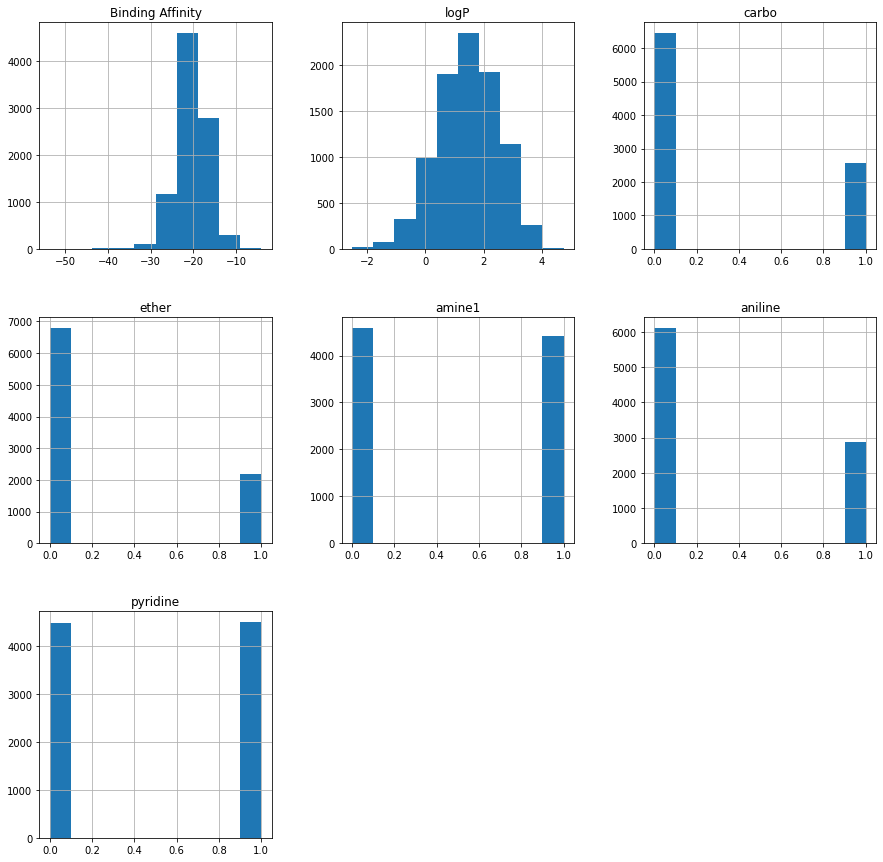

In [ ]:
#Data Vizualization
df.hist(figsize=[15,15])

In [ ]:
#Generate 3Channel images
def generate(mol):
     return mol_to_image(mol)
df["molimage"]=df['mol'].apply(generate) 

In [ ]:
#Generate 4 channel images
#def generate(mol):
 #   return chemcepterize_mol(mol, embed=20)
#df["molimage"] = df["mol"].apply(generate)

In [ ]:
# x and y
x=np.array(list(df["molimage"]))

#y for QSAR
y= df["logP"].values

#y for classification
ycarbo=np.array(df['carbo'])
yether=np.array(df['ether'])
yamine=np.array(df['amine1'])
yanil=np.array(df['aniline'])
ypyr=np.array(df['pyridine'])

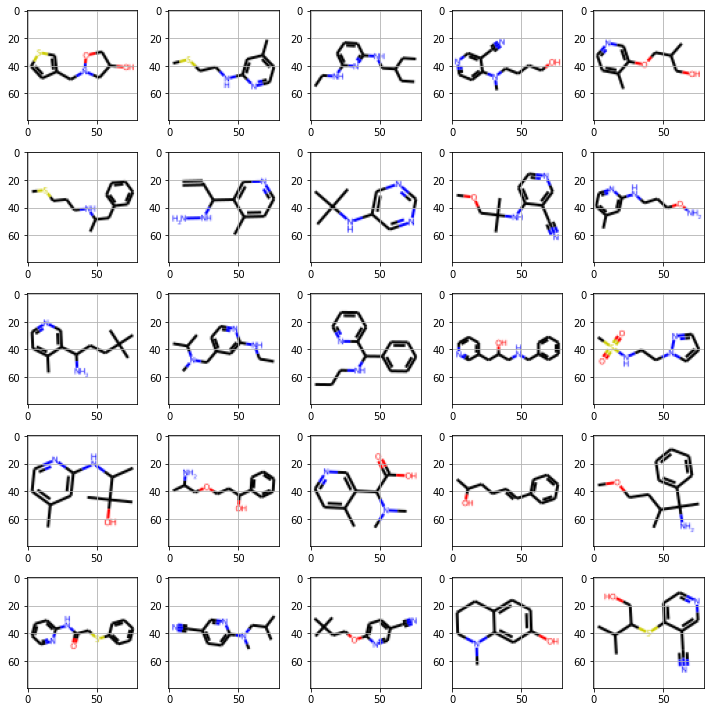

In [ ]:
#visualize molecules
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.grid('on')
    
    img_index = np.random.randint(0, len(x))
    plt.imshow(x[img_index])
    
    #actual_label = y[img_index].astype(int)
    #plt.xlabel("Lipophilicity: {} ".format(actual_label))
    
plt.tight_layout()
plt.show()

In [ ]:
#Normalization
#Case of 3channels
x=x/255.

In [ ]:
#Splitting Data
x_train, x_test, y_train , y_test, y_train_amine, y_test_amine,y_train_pyr,y_test_pyr = train_test_split(x,y,yamine,ypyr, test_size=0.3, shuffle=True, random_state=7)
x_train, x_val, y_train,y_val, y_train_amine, y_val_amine, y_train_pyr,y_val_pyr = train_test_split(x_train,y_train, y_train_amine,y_train_pyr, test_size=0.2, shuffle=True, random_state=7)

In [ ]:
print(x_val.shape)
print(y_train_pyr.shape)

(1260, 80, 80, 3)
(5040,)


Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
  [layers.RandomFlip("horizontal",input_shape=(80,80,3)),
    layers.RandomRotation(0.1)])

#ended up not needing data augmentation

Classification Model

In [ ]:
#creating a multioutput model
class MultiOutputModel():
    
    #Used to generate a multi-output model. This CNN model contains 3 branches, 2 classification branches for functional groups (whichever functional groups are chosen to experiment on).
    #And 1 branch for the prediction of lipophilicity values (a QSAR study)
    #Each branch contains a sequence of Convolutional Layers that is defined on the make_default_hidden_layers method.
    
    def hidden_layers(self, inputs):
        #Used to generate a default set of hidden layers
        x = layers.Conv2D(256, (3, 3),activation="relu", padding="same")(inputs)
        x = layers.Conv2D(128, (3, 3),activation="relu" ,padding="same")(x)
        x = layers.MaxPooling2D(pool_size=(3, 3))(x)
        
        x = layers.Conv2D(128, (3, 3),activation="relu" ,padding="same")(x)
        x = layers.Conv2D(64, (3, 3),activation="relu" ,padding="same")(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Conv2D(64, (3, 3),activation="relu", padding="same")(x)
        x = layers.Conv2D(64, (3, 3),activation="relu" ,padding="same")(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x= layers.Dropout(0.3)(x)
        
        x = layers.Conv2D(32, (3, 3),activation="relu" ,padding="same")(x)
        #x = layers.Conv2D(48, (3, 3),activation="relu" ,padding="same")(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        
        
        return x


    def build_logP_branch(self, inputs):
  
        #x = data_augmentation(input)
        x = layers.Conv2D(64,(4,4),activation="relu",padding="same")(inputs)
        x = layers.Conv2D(64,(3,3),activation="relu",padding="same")(x)
        x = layers.MaxPool2D()(x)
        x = layers.Dropout(0.4)(x)
        
        x = layers.Conv2D(64,(3,3),activation="relu",padding="same")(x)
        x = layers.MaxPool2D()(x)
        x= layers.Dropout(0.4)(x)
        
        x = layers.Conv2D(48,(4,4),activation="relu",padding="same")(x)
        x = layers.Conv2D(32,(3,3),activation="relu",padding="same")(x)
        x = layers.MaxPool2D()(x)
        x = layers.Dropout(0.4)(x)
        
        x = layers.Flatten()(x)
        x = layers.Dropout(0.3)(x)
        x = layers.Dense(32,activation='relu')(x)
        x = layers.Dense(100,activation='relu')(x)
        x = layers.Dense(1, activation="linear", name= 'logP_output')(x)
        return x

    def build_amine_branch(self, inputs):
  
        x = self.hidden_layers(inputs)
        x = layers.Flatten()(x)
        x = layers.Dense(48, activation="relu")(x)
        x = layers.Dropout(0.4)(x)
        x = layers.Dense(1,activation="sigmoid", name="amine_output")(x)
        return x
      
    def build_pyr_branch(self, inputs):
  
        x = self.hidden_layers(inputs)
        x = layers.Flatten()(x)
        x = layers.Dense(48, activation="relu")(x)
        x = layers.Dropout(0.3)(x)
        x = layers.Dense(1,activation="sigmoid", name="pyr_output")(x)
        
        return x
      



    def assemble_full_model(self, width, height):
        #assemble our multi-output model CNN.
        
        input_shape = (height, width, 3)
        inputs = layers.Input(shape=input_shape)
        logP_branch=self.build_logP_branch(inputs)
        amine_branch = self.build_amine_branch(inputs)
        pyr_branch = self.build_pyr_branch(inputs)


        model = keras.Model(inputs=inputs,
                     outputs = [logP_branch,amine_branch,pyr_branch],
                     name="chem_net")
        return model
    
model = MultiOutputModel().assemble_full_model(80,80)


In [ ]:
#model.summary()

In [ ]:
opt=tf.keras.optimizers.Adam(learning_rate=0.0005,beta_1=0.7,beta_2=0.899,epsilon=2e-07,amsgrad=False,name='Adam')
model.compile(optimizer= opt,
              loss ={'logP_output':'mse',
                                      'amine_output':'binary_crossentropy',
                                      'pyr_output':"binary_crossentropy"},
               metrics={'logP_output':"mae",
                        'amine_output':'accuracy',
                        'pyr_output': 'accuracy'})

In [ ]:
history=model.fit(x=x_train , y={'logP_output': y_train, 'amine_output': y_train_amine, 'pyr_output':y_train_pyr},
                  epochs=100,
                  batch_size=64,
                  validation_data=(x_val,{'logP_output':y_val, 'amine_output': y_val_amine, 'pyr_output':y_val_pyr}))

Epoch 1/100
79/79 [==============================] - 47s 355ms/step - loss: 2.6175 - logP_output_loss: 1.2298 - amine_output_loss: 0.6938 - pyr_output_loss: 0.6939 - logP_output_mae: 0.8953 - amine_output_accuracy: 0.4996 - pyr_output_accuracy: 0.5105 - val_loss: 2.7152 - val_logP_output_loss: 1.3271 - val_amine_output_loss: 0.6929 - val_pyr_output_loss: 0.6953 - val_logP_output_mae: 0.9398 - val_amine_output_accuracy: 0.5087 - val_pyr_output_accuracy: 0.4992
Epoch 2/100
79/79 [==============================] - 24s 302ms/step - loss: 2.2337 - logP_output_loss: 0.8700 - amine_output_loss: 0.6899 - pyr_output_loss: 0.6738 - logP_output_mae: 0.7478 - amine_output_accuracy: 0.5149 - pyr_output_accuracy: 0.5621 - val_loss: 2.2464 - val_logP_output_loss: 0.9379 - val_amine_output_loss: 0.6821 - val_pyr_output_loss: 0.6264 - val_logP_output_mae: 0.7790 - val_amine_output_accuracy: 0.5437 - val_pyr_output_accuracy: 0.6651
Epoch 3/100
79/79 [==============================] - 24s 305ms/step - lo

Visualize training history

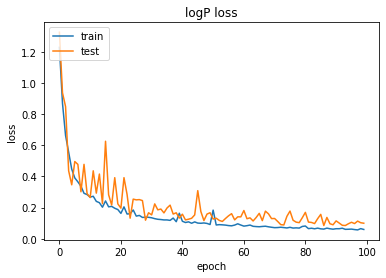

In [ ]:
#Lipophilicity

plt.plot(model.history.history['logP_output_loss'])
plt.plot(model.history.history['val_logP_output_loss'])
plt.title('logP loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


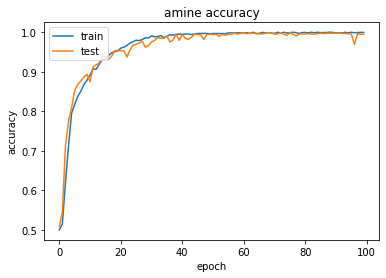

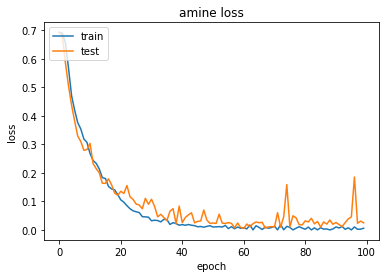

In [ ]:
#Amine functional groupement
plt.plot(model.history.history['amine_output_accuracy'])
plt.plot(model.history.history['val_amine_output_accuracy'])
plt.title('amine accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model.history.history['amine_output_loss'])
plt.plot(model.history.history['val_amine_output_loss'])
plt.title('amine loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

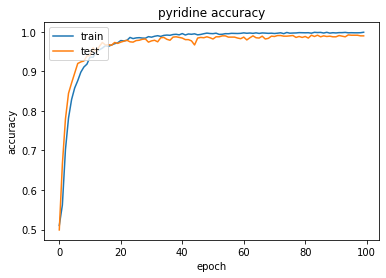

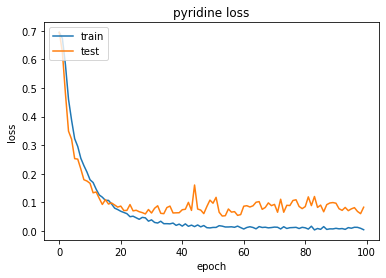

In [ ]:
#Pyridine functional groupement
plt.plot(model.history.history['pyr_output_accuracy'])
plt.plot(model.history.history['val_pyr_output_accuracy'])
plt.title('pyridine accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model.history.history['pyr_output_loss'])
plt.plot(model.history.history['val_pyr_output_loss'])
plt.title('pyridine loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Evaluation of model

In [ ]:
model.evaluate(x=x_test,y={'logP_output':y_test, 'amine_output': y_test_amine, 'pyr_output':y_test_pyr}, batch_size=32)


85/85 [==============================] - 6s 60ms/step - loss: 0.2773 - logP_output_loss: 0.1031 - amine_output_loss: 0.0043 - pyr_output_loss: 0.1698 - logP_output_mae: 0.2463 - amine_output_accuracy: 0.9989 - pyr_output_accuracy: 0.9822


[0.2772921323776245,
 0.1031399518251419,
 0.004335862584412098,
 0.1698162704706192,
 0.24625013768672943,
 0.9988889098167419,
 0.9822221994400024]

Prediction and result visualization

In [ ]:
logP_pred, amine_pred, pyr_pred = model.predict(x_test)

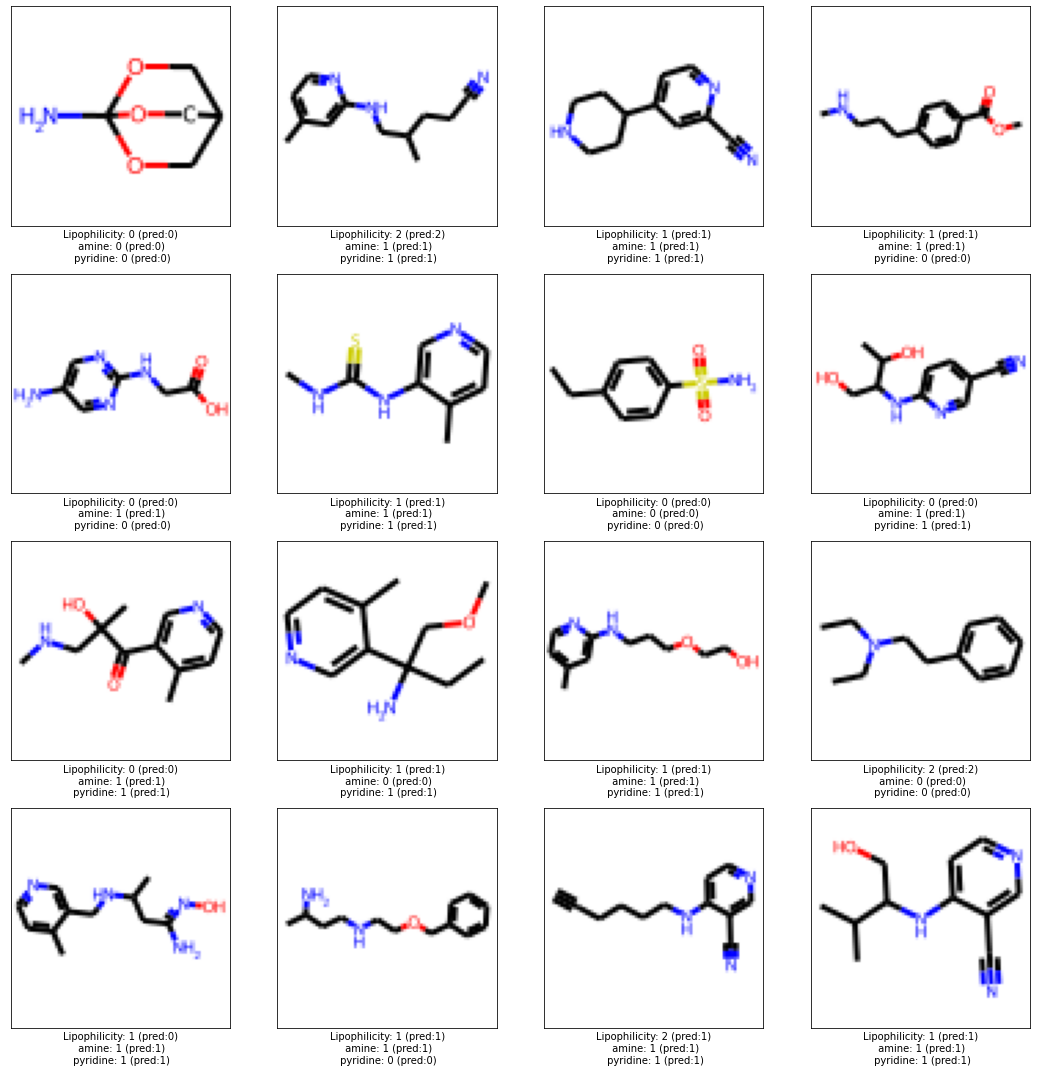

In [ ]:
plt.figure(figsize=(15,15))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off')
    
    img_index = np.random.randint(0, len(x_test))
    plt.imshow(x_test[img_index])
    
    #carboxyl grp
    actual_logP = int(y_test[img_index])
    predicted_logP = int(logP_pred[img_index])
    
    #amine grp
    actual_am = int(y_test_amine[img_index])
    predicted_am = int(amine_pred[img_index])
    
    #pyridine grp
    actual_pyr = int(y_test_pyr[img_index])
    predicted_pyr = int(pyr_pred[img_index])
    
    plt.xlabel("Lipophilicity: {} (pred:{})\n amine: {} (pred:{})\n pyridine: {} (pred:{})".format(
        actual_logP,  predicted_logP, actual_am , predicted_am, actual_pyr , predicted_pyr ))
    
    
plt.tight_layout()
plt.show()

Classification report 

In [ ]:
from sklearn.metrics import classification_report

amine_report = classification_report(y_test_amine.astype(int), amine_pred.astype(int))
pyridine_report = classification_report(y_test_pyr.astype(int), pyr_pred.astype(int))
print(amine_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1419
           1       1.00      0.99      1.00      1281

    accuracy                           1.00      2700
   macro avg       1.00      1.00      1.00      2700
weighted avg       1.00      1.00      1.00      2700



In [ ]:
print(pyridine_report)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1365
           1       1.00      0.95      0.97      1335

    accuracy                           0.98      2700
   macro avg       0.98      0.97      0.98      2700
weighted avg       0.98      0.98      0.98      2700



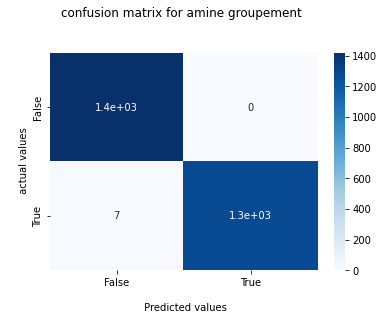

In [ ]:
#Visualize Confusion matrix
cm_a= confusion_matrix(y_test_amine.astype(int), amine_pred.astype(int))
cm_p= confusion_matrix(y_test_pyr.astype(int), pyr_pred.astype(int))

ax= sns.heatmap(cm_a,annot= True, cmap="Blues")
ax.set_title('confusion matrix for amine groupement \n\n')
ax.set_xlabel("\n Predicted values")
ax.set_ylabel("\n actual values")

ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

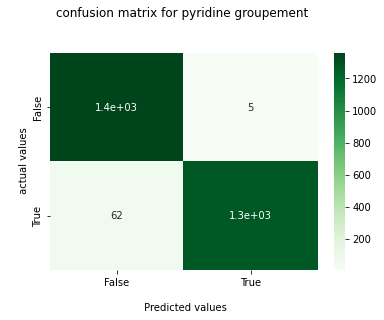

In [ ]:
ax= sns.heatmap(cm_p,annot= True, cmap="Greens")
ax.set_title('confusion matrix for pyridine groupement \n\n')
ax.set_xlabel("\n Predicted values")
ax.set_ylabel("\n actual values")

ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

Regression Report

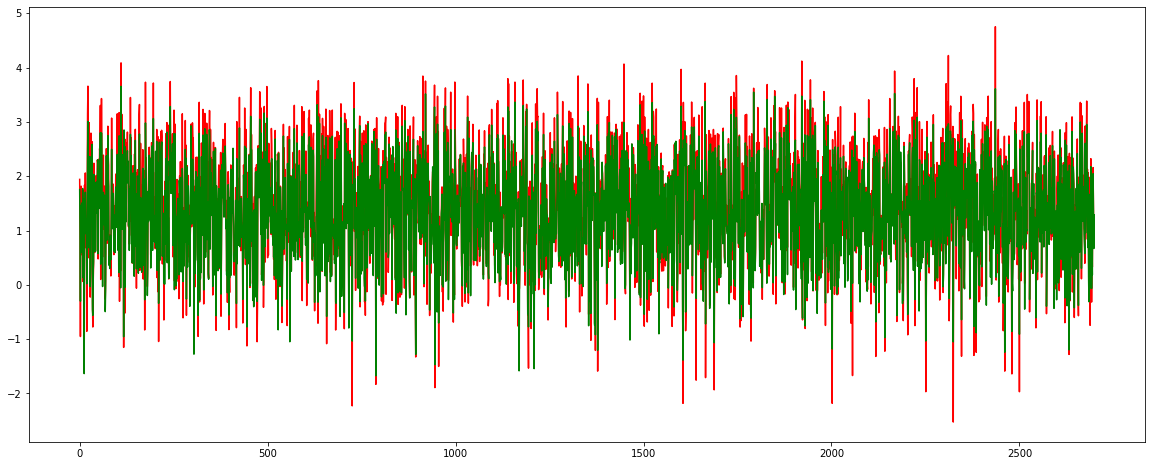

In [ ]:
#Plotting predicted and expected values of Lipophilicity
plt.figure(figsize=(20,8))
plt.plot(y_test, color='r', label="expected")
plt.plot( logP_pred, color='g',label="predicted")
plt.show()

In [ ]:
#R2 score
r2_score(y_test, logP_pred)

0.909484935058487